In [1]:
import pandas as pd
import numpy as np
import time 
import os.path
import datetime
import help as hp
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from xgboost.sklearn import XGBRegressor

from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt


# 为notebook提供更加漂亮的可视化
%matplotlib inline

## 读取经过处理后的全量数据

B_all_train_data_20170102_20100326.csv  



In [2]:
all_data=pd.read_csv("B_all_train_data_20170102_20100326.csv")

### 取训练数据

In [3]:
train_data=all_data[(all_data['date']>=20170102) & (all_data['date']<=20170312)]


In [4]:
train_data.head()

,grid_id,date,hour,car_number,temp,humidity,wind_speed,weather,dayofweek
0,51,20170102,8,9.0,11,94,7.2,4,1
1,51,20170102,9,14.0,13,88,10.8,4,1
2,51,20170102,10,7.0,13,88,18.0,2,1
3,51,20170102,11,8.0,15,77,10.8,2,1
4,51,20170102,12,7.0,15,72,10.8,4,1


## 观察数据

In [5]:
def distribution_by_featur(data, x_feature, y_feature, date_flag=True):
    if date_flag:
        #日期传入是int64，转成字符串
        dates=data[x_feature].astype(np.str)
        xs = [datetime.datetime.strptime(d, '%Y%m%d').date() for d in dates.values]
        x_lables=dates[1:len(dates):7]
        ticks=xs[1:len(xs):7]
        
    else:
        dates=data[x_feature]
        xs = dates.values
    
    ys=data[y_feature].values
    
    plt.plot(xs, ys)
    if date_flag:
        plt.xticks(ticks, x_lables)
        plt.xlabel('Date')
    else:
        plt.xlabel('Day of week')
    plt.ylabel("car numbers")
    plt.title("Distribution of car numbers by {}".format(x_feature))
    plt.gcf().autofmt_xdate()  # 自动旋转日期标记
    plt.show()

In [6]:
# 按星期的天数统计车量分布情况
byweekday = train_data.groupby('dayofweek')
#byweekday=byweekday['car_number'].mean().reset_index()
#byweekday=byweekday['car_number'].count().reset_index()
byweekday=byweekday['car_number'].sum().reset_index()
byweekday

,dayofweek,car_number
0,1,99253.0
1,2,104409.0
2,3,103216.0
3,4,104765.0
4,5,102809.0
5,6,92929.0
6,7,81863.0


In [7]:
# 按日期统计车辆的分布情况 
byday = train_data.groupby('date')
byday=byday['car_number'].sum().reset_index()
byday.head()

,date,car_number
0,20170102,9996.0
1,20170103,10537.0
2,20170104,11001.0
3,20170105,9790.0
4,20170106,11004.0


In [8]:
# 按小时统计车辆的分布情况 
byhour = train_data.groupby('hour')
byhour=byhour['car_number'].mean().reset_index()
byhour

,hour,car_number
0,8,10.682000
1,9,12.894000
2,10,13.718571
3,11,13.089429
4,12,12.799714
5,13,12.518857
6,14,12.795143
7,15,13.237429
8,16,13.691143
9,17,13.103143


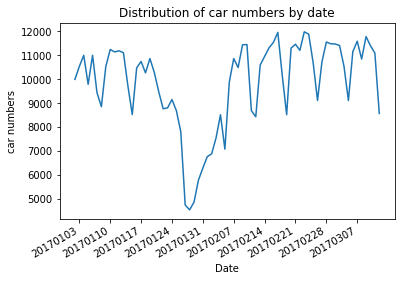

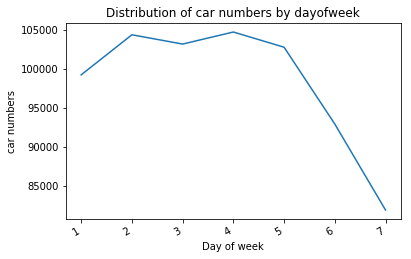

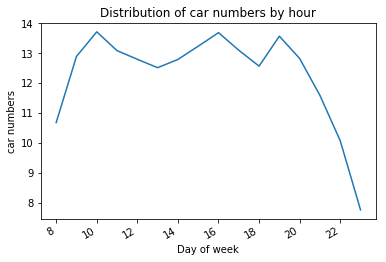

In [9]:
distribution_by_featur(byday, "date", "car_number", True)
distribution_by_featur(byweekday, "dayofweek", "car_number",False)
distribution_by_featur(byhour, "hour", "car_number",False)

从上面的分布图可以看出
- 春节期间：20170127~20170202，车流量是个低俗；可能从训练数据中删除此部分会更好
- 周末的车流量比工作日多
- 上行9到10点，下午16点，19点是流量高峰

In [10]:
# 观察一下日车流量小于6000的日期
byday[byday['car_number']<=6000]

,date,car_number
25,20170127,4749.0
26,20170128,4546.0
27,20170129,4869.0
28,20170130,5786.0


都是春节期间的日期，从训练数据中删除这部分数据

In [11]:
# 观察一下日车流量大于6000的日期
df_tmp=byday[byday['car_number']>10000]

def get_dayofweek(date_str):
    date = datetime.datetime.strptime(str(date_str),'%Y%m%d')
    
    return date.isoweekday()

df_tmp['dayofweek']=df_tmp['date'].apply(get_dayofweek)
df_tmp

E:\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,car_number,dayofweek
1,20170103,10537.0,2
2,20170104,11001.0,3
4,20170106,11004.0,5
7,20170109,10529.0,1
8,20170110,11244.0,2
9,20170111,11145.0,3
10,20170112,11189.0,4
11,20170113,11110.0,5
14,20170116,10478.0,1
15,20170117,10744.0,2


流量大的日期，都是工作日的日期

### 增加节日数据

In [12]:
#20170102-元旦、
#工作日、休息日
#df_festival=pd.read_csv("节日_工作日_数据.csv")
#df_festival.info()

### 删除春节放假的数据

In [13]:
all_data_df=all_data[(all_data['date']<20170127) | (all_data['date']>20170202)]

In [14]:
all_data_df.shape

(61600, 9)

## 归一化、OneHot编码

In [15]:
# 标准化处理连续型和离散型特征
def nomalize_features(data):
    featureConCols = ['grid_id','temp','humidity','wind_speed','hour']  #连续型
    featureCatCols = ['weather','dayofweek']    #离散型
    #date字段，考虑删除，当连续型和离散型都不合适
    
    # 我们把连续值的属性放入一个dict中
    dataFeatureCon = data[featureConCols]
    X_dictCon = dataFeatureCon.T.to_dict().values() 

    # 把离散值的属性放到另外一个dict中
    dataFeatureCat = data[featureCatCols]
    X_dictCat = dataFeatureCat.T.to_dict().values() 

    # 向量化特征
    vec = DictVectorizer(sparse = False)
    X_vec_cat = vec.fit_transform(X_dictCat)
    X_vec_con = vec.fit_transform(X_dictCon)
    
    # 标准化连续值数据,让连续值属性处理过后均值为0，方差为1
    scaler = preprocessing.StandardScaler().fit(X_vec_con)
    X_vec_con = scaler.transform(X_vec_con)
    
    # 离散特征one-hot编码
    enc = preprocessing.OneHotEncoder()
    enc.fit(X_vec_cat)
    X_vec_cat = enc.transform(X_vec_cat).toarray()
    
    #连续型、离散型特征拼接
    X_vec = np.concatenate((X_vec_con,X_vec_cat), axis=1)

    #结果值
    Y_vec = data['car_number'].values.astype(float)
    
    return X_vec, Y_vec


### 按记录数切分验证数据和训练数据【因为数据标准化后，没有日期字段】
- 所有数据一共12周，前10周是训练数据加验证集
- 每一天800条记录：16*50

| 数据集 | 天数  | 记录数 | 起始下标 | 终止下标 |
| :-: | :-:  | :-: | 
| 训练集  | 49 | 39200 | 0 | 39200|
| 验证集  | 14 | 11200 | 39200|50400|
| 测试集  | 14 | 11200 | 50400|61600|

- 训练数据到20170226  8周减去春节放假一周，共49天 39200条
- 验证数据后两周:20170227-20170312  14天  11200条
- 测试数据：20170313-20170326  14天  14*800=11200条

In [16]:
#按日期排序后才能按记录下标切分数据
df_tmp=all_data_df.sort(columns=['date','hour']).reset_index(drop=True)
df_tmp.head()

E:\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


,grid_id,date,hour,car_number,temp,humidity,wind_speed,weather,dayofweek
0,51,20170102,8,9.0,11,94,7.2,4,1
1,52,20170102,8,1.0,11,94,7.2,4,1
2,53,20170102,8,3.0,11,94,7.2,4,1
3,54,20170102,8,2.0,11,94,7.2,4,1
4,55,20170102,8,2.0,11,94,7.2,4,1


### 取测试数据

In [17]:
test_data=df_tmp[(df_tmp['date']>=20170313)].reset_index(drop=True)
test_data.head()

,grid_id,date,hour,car_number,temp,humidity,wind_speed,weather,dayofweek
0,51,20170313,8,0.0,9,93,25.2,2,1
1,52,20170313,8,0.0,9,93,25.2,2,1
2,53,20170313,8,0.0,9,93,25.2,2,1
3,54,20170313,8,0.0,9,93,25.2,2,1
4,55,20170313,8,0.0,9,93,25.2,2,1


In [18]:

X_all, y_all=nomalize_features(df_tmp)

x_train=X_all[0:39200]
y_train=y_all[0:39200]
x_val=X_all[39200:50400]
y_val=y_all[39200:50400]
x_test=X_all[50400:61600]
y_test=y_all[50400:61600]
xx_train=X_all[0:50400]
yy_train=y_all[0:50400]

print("x_train rows=", x_train.shape)
print("y_train rows=", y_train.shape)
print("x_val rows=", x_val.shape)
print("y_val rows=", y_val.shape)
print("x_test rows=", x_test.shape)
print("y_test rows=", y_test.shape)

x_train rows= (39200, 17)
y_train rows= (39200,)
x_val rows= (11200, 17)
y_val rows= (11200,)
x_test rows= (11200, 17)
y_test rows= (11200,)


## 模型训练

In [33]:

def my_predict(model, name, x_test):
    #预测测试集
    y_pred = model.predict(x_test)
    
    df_y_test=pd.DataFrame(y_pred) #0313--0326的预测值
    df_y_test.rename(columns={0:'car_number'}, inplace=True) #先转成df，再合并
    
    df_test_pred=test_data[['grid_id','date','hour']].reset_index(drop=True)   #0313--0326的基础数据
    df_rel= pd.concat([df_test_pred, df_y_test], axis=1)
    
    df_rel=df_rel[(df_rel['hour']>=9) & (df_rel['hour']<=22)] #去掉8点和23点的数据
    
    df_rel.rename(columns={'date':'day'}, inplace=True) #结果文件要求列名为day
    now_time = datetime.datetime.now()
    df_rel.to_csv("data/pred/B_{}_{}.csv".format(name, now_time.strftime('%Y%m%d%H%M%S')), index=False)
    
    df_rel['car_number']=df_rel['car_number'].apply(np.ceil)
    df_rel.to_csv("data/pred/B_{}_{}_ceil.csv".format(name, now_time.strftime('%Y%m%d%H%M%S')), index=False)
    return df_rel

In [20]:
watchlist = [(x_train, y_train),(x_val, y_val)]
xgbr = XGBRegressor(
    learn_rate = 0.1,
    max_depth = 10,
    min_child_weight = 3,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.7,
    reg_alpha = 1,
    objective = 'reg:linear',
    n_estimators = 1000,
    random_state = 1
)

xgbr.fit(x_train, y_train, eval_set=watchlist,early_stopping_rounds=10)

[0]	validation_0-rmse:14.0483	validation_1-rmse:15.0814
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:13.1808	validation_1-rmse:14.1959
[2]	validation_0-rmse:12.4421	validation_1-rmse:13.4167
[3]	validation_0-rmse:11.8019	validation_1-rmse:12.7675
[4]	validation_0-rmse:10.7759	validation_1-rmse:11.7365
[5]	validation_0-rmse:9.85354	validation_1-rmse:10.7993
[6]	validation_0-rmse:9.06095	validation_1-rmse:9.9688
[7]	validation_0-rmse:8.67399	validation_1-rmse:9.55827
[8]	validation_0-rmse:8.34654	validation_1-rmse:9.22472
[9]	validation_0-rmse:8.07069	validation_1-rmse:8.92845
[10]	validation_0-rmse:7.46069	validation_1-rmse:8.30965
[11]	validation_0-rmse:7.2572	validation_1-rmse:8.11303
[12]	validation_0-rmse:7.0829	validation_1-rmse:7.93491
[13]	validation_0-rmse:6.5873	validation_1-rmse:7.42581
[14]	validation_0-rmse:6.15021	validation_1-rmse:6.97804


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learn_rate=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=10, min_child_weight=3, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=1, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [21]:
#预测验证集
y_pred = xgbr.predict(x_val)

print ("modele:", "RMSE:",np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print ("modele:", "RMSE CEIL:",np.sqrt(metrics.mean_squared_error(y_val, np.ceil(y_pred))))
print ("modele:", "RMSE round:",np.sqrt(metrics.mean_squared_error(y_val, np.round(y_pred))))
print ("modele:", "RMSE floor:",np.sqrt(metrics.mean_squared_error(y_val, np.floor(y_pred))))

modele: RMSE: 4.0044552275573
modele: RMSE CEIL: 3.956177357717205
modele: RMSE round: 4.015361129462704
modele: RMSE floor: 4.133972924785205


In [34]:
my_predict(xgbr, "XGBRegressor", x_test)

,grid_id,day,hour,car_number
50,51,20170313,9,7.0
51,52,20170313,9,-0.0
52,53,20170313,9,3.0
53,54,20170313,9,5.0
54,55,20170313,9,6.0
55,56,20170313,9,8.0
56,57,20170313,9,2.0
57,58,20170313,9,6.0
58,59,20170313,9,11.0
59,60,20170313,9,14.0
